# Capstone 2 Project: Modeling Traffic flow at Mill Road (UK)

### Statement: How can temporal data from traffic sensors be used to reasonably predict hourly traffic flow by looking at near term and long term patterns in Mill Road traffic data?

### Context:
Badly timed traffic lights can cause several problems like traffic congestion, dissatisfaction for drivers, dissatisfaction for drivers, increased risk of accidents and higher pollution. Many traffic controllers use real-time traffic data to time their signals. However these are often expensive to set up and operate.
One solution to this is implementing predictive models to time the signal, which will decrease dependence on real time sensor information, possibly eliminating the need for several sensors or allow cheaper sensors and reduce costs of installation and operation. 
<br>This project attempts to create such a model, using data from the Mill Road Project. This is hourly data for the flow of vehicles and pedestrians at the intersection.
<br>This data will be analyzed to develop a model that will predict the traffic for the next hour based on a combination of expected traffic from several days of data at the time, and recent traffic hourly data. This output can then be used to time the traffic signal appropriately.


In [1]:
import math as mth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer,FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import linregress
from datetime import datetime, timedelta
import random
import sys
import os
from io import StringIO
import json # library to handle JSON files
from matplotlib import cm,colors
from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim # convert an place into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import camelot
import requests
from IPython import get_ipython

In [2]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

General Classes and Functions

In [3]:
# Class to create Plots grid

from itertools import product,cycle,combinations
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Plotsgrid:

    """ Creates a nxn grid of plots for an input df. Shows blank for grid values exceeding number of columns of df"""


    def __init__(self,df):
        self.df=df 

    def figure_params(self,size_fac1,size_fac2):
        df=self.df
        n_data_cols=len(df.columns)
        self.n_data_cols=n_data_cols 

        n_cols=int(n_data_cols**.5)
        n_rows=0
        while n_rows*n_cols<n_data_cols:
            n_rows+=1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(int(size_fac1*n_data_cols),int(size_fac2*n_rows)))
        
        # Flatten the axs array for easier iteration
        self.axs = axs.flatten()

    # Loop through the axes and Hist plot
    def histplots(self,bins=-1,density=False):
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            if bins==-1:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax)  # Plot the histogram on the current axis
            else:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins)  # Plot the histogram on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Box plot
    def boxplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Initialize figure 
        self.figure_params(2.5,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(df.columns)
        for i,ax in enumerate(self.axs):
            try:
                if i==self.n_data_cols:
                    ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                    break
                col = next(cycler)  # Get the next column name
                sns.boxplot(data=df, y=col, ax=ax)  # Plot the boxplot on the current axis
            except Exception as E:
                print(E)
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Line plot
    def lineplots(self):
        # Initialize figure 
        self.figure_params(5,5)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            print(col)
            sns.lineplot(data=self.df,x=self.df.index,y=col, ax=ax)  # Plot the Line on the current axis
        plt.tight_layout()
        plt.show()

    def scatterplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Get all numeric combinations
        col_combinations = list(combinations(df.columns, 2))
        num_combs = len(col_combinations)
        
        # Calculate grid size based on the number of combinations
        n_cols = int(np.ceil(np.sqrt(num_combs)))
        n_rows = int(np.ceil(num_combs / n_cols))

        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(int(2*n_cols),int(2.5*n_rows)))
        plt.suptitle('Pairwise Scatter with higher correlations shown brighter')
        axs = axs.flatten()  # Flatten the axes array for easier iteration

        # Iterate through each combination and plot scatterplots
        for i, (col_x, col_y) in enumerate(col_combinations):
            ax = axs[i]

            df_x_y=df[[col_x,col_y]].dropna()

            x = df_x_y[col_x]
            y = df_x_y[col_y]

            # Calculate Pearson correlation and p-value
            if len(x) > 1 and len(y) > 1:  # Ensure there are enough data points
                corr, p_value = pearsonr(x, y)
                corr_array=np.array([corr]*x.shape[0])
                # Scatter plot with colored points
                sns.scatterplot(x=x, y=y, ax=ax,hue=corr_array, palette='coolwarm',hue_norm=(-1,1),legend=False)

                # Add correlation coefficient and p-value as the legend
                ax.text(0.05, 0.95, f"r = {corr:.2f}\np = {p_value:.2e}", 
                        transform=ax.transAxes, fontsize=7, verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="black"))
                
                # Set plot labels
                ax.set_xlabel(col_x)
                ax.set_ylabel(col_y)

        # Hide any extra subplots
        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)
        plt.tight_layout()
        plt.show()

## Import Data

In [4]:
#data_url='https://query.data.world/s/wj2wwszc2ldqikthjxld4zazaayexw?dws=00000'
# Import
#df=pd.read_csv(data_url)
df=pd.read_csv('mill_road_traffic_data.csv',index_col=0)
df.head()

,Local Time (Sensor),Date,Time,countlineName,direction,Car,Pedestrian,Cyclist,Motorbike,Bus,OGV1,OGV2,LGV
0,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,0,0,5
1,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,out,51,6,0,0,0,1,0,1
2,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,in,0,0,0,0,0,0,0,0
3,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,out,0,2,0,0,0,0,0,0
4,03/06/2019 01:00,03/06/2019,01:00:00,S13_MiltonRoad_CAM003,in,66,2,5,4,0,0,0,4


In [5]:
df_sensors=df.copy()

In [6]:
# Location information
df_loc=pd.read_csv('mill-road-trial-sensor-point-locations-2.csv')
df_loc

,Sensor Reference,Sensor Type,Street location,Column number,Easting,Northing
0,1,Vivacity sensor,362 Mill Rd,L6RAS,52.196510,0.153030
1,2,Vivacity sensor,Mill Rd (SO 1 Mortimer Rd),L62RAS,52.201920,0.132450
2,3,Vivacity sensor,108 Coleridge Rd,L10RCI,52.190930,0.145920
3,4,Vivacity sensor,114 Vinery Rd,L11RJJ,52.199990,0.152570
4,5,Vivacity sensor,2 Tenison Rd,L1SAI (1),52.199940,0.136790
5,6,Vivacity sensor,OP 6 Station Rd,L2SAO,52.194855,0.132876
6,7,Vivacity sensor,151/153 Coldhams Ln,L36RJD,52.203770,0.152010
7,8,Vivacity sensor,117 Cherry Hinton Rd,L13RCH,52.188320,0.142270
8,10,Vivacity sensor,142 Perne Road,L21RIW,52.192390,0.154670
9,11,Vivacity sensor,O/S ARU East Road,L29RBS,52.204070,0.132940


## Perform Exploratory Data Analysis

Create Geolocator using Nominatim and Obtain Location info. for the places

In [7]:
geoagent="explorer"
geolocator = Nominatim(user_agent=geoagent)

In [8]:
# Location for city
city='London, United Kingdom'
loc=geolocator.geocode(city)
latitude=loc.latitude
longitude=loc.longitude
latitude,longitude

(51.4893335, -0.14405508452768728)

In [9]:
# Rename the 'Easting' and 'Northing' columns to 'Sensor Latitude' and 'Sensor Longitude'
df_loc.rename(columns={'Easting':'Sensor Latitude','Northing':'Sensor Longitude'},inplace=True)

In [10]:
df_loc.head(1)

,Sensor Reference,Sensor Type,Street location,Column number,Sensor Latitude,Sensor Longitude
0,1,Vivacity sensor,362 Mill Rd,L6RAS,52.19651,0.15303


Visualize sensors on map

In [11]:
# Sensor distribution on map
latitude=np.median(df_loc['Sensor Latitude'])
longitude=np.median(df_loc['Sensor Longitude'])

map_clusters = folium.Map(location=[latitude, longitude],zoom_start=12)

for index,row in df_loc.iterrows():

    num,street,lat,lon=row['Sensor Reference'],row['Street location'],row['Sensor Latitude'],row['Sensor Longitude']
    label = folium.Popup(f"{num}, Street: {street}", parse_html=True)

    folium.RegularPolygonMarker(
        [lat, lon],
        radius=7,
        number_of_sides=5,
        popup=label,
        color='red',
        fill=True,
        fill_color=None,
        fill_opacity=0.7,
                        ).add_to(map_clusters)

map_clusters

In [12]:
# Make a list of sensor names
sensors_list=df_sensors.countlineName.unique().tolist()
sensors_list

['S10_EastRoad_CAM003',
 'S12_DevonshireRoad_CyclePath_CAM003',
 'S13_MiltonRoad_CAM003',
 'S14_HillsRoad_CAM003',
 'S15_NewmarketRoad_CAM003',
 'S16_PerneRoad_CAM003',
 'S18_MIltonRd_Ped_Path_RHS_CAM004',
 'S18_MiltonRd_CAM004',
 'S18_MiltonRd_Ped_Path_LHS_CAM004',
 'S19_MiltonRd_CAM004',
 'S19_MiltonRd_Ped_Path_RHS_CAM004',
 'S19_MiltonRd_Ped_path_LHS_CAM004',
 'S1_MillRoad_CAM003',
 'S20_CambridgeRd_CAM004',
 'S20_CambridgeRd_Ped_Path_LHS_CAM004',
 'S20_CambridgeRd_Ped_Path_RHS_CAM004',
 'S21_HistonRd_CAM004',
 'S21_HistonRd_Ped_Path_RHS_CAM004',
 'S21_HistonRd_Pedestrian_LHS_CAM004',
 'S2_MillRoad_CAM003',
 'S3_ColeridgeRoad_CAM003',
 'S4_VineryRoad_CAM003',
 'S5_TenisonRoad_CAM003',
 'S6_StationRoad_CAM003',
 'S7_ColdhamsLane_CAM003',
 'S8_CherryHintonRoad_CAM003',
 's24_hills_road_Ped_RHS_cam005',
 's24_hills_road_cam005',
 's25_hills-road_ped_LHS_cam005',
 's25_wulfstan_way_cam005',
 's25_wulfstan_way_ped_LHS_cam005',
 's25_wulfstan_way_ped_RHS_cam005',
 's26_nightinagle_avenue_

### Analyse the time deltas

In [13]:
df_sensors.Time.unique()

array(['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00',
       '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00',
       '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00', '00:00:00'], dtype=object)

In [14]:
# Since the times are in hours only, we can create an 'hour' column by extracting the first two characters of the string and converting to int
df_sensors['hour']=df_sensors.Time.apply(lambda x:int(x[:2]))
df_sensors.head()

,Local Time (Sensor),Date,Time,countlineName,direction,Car,Pedestrian,Cyclist,Motorbike,Bus,OGV1,OGV2,LGV,hour
0,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,0,0,5,1
1,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,out,51,6,0,0,0,1,0,1,1
2,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,in,0,0,0,0,0,0,0,0,1
3,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,out,0,2,0,0,0,0,0,0,1
4,03/06/2019 01:00,03/06/2019,01:00:00,S13_MiltonRoad_CAM003,in,66,2,5,4,0,0,0,4,1


In [15]:
# Add a column for total traffic
df_sensors['Total']=df_sensors[['Car',	'Pedestrian',	'Cyclist',	'Motorbike',	'Bus',	'OGV1',	'OGV2',	'LGV']].sum(axis=1)
df_sensors.head()

,Local Time (Sensor),Date,Time,countlineName,direction,Car,Pedestrian,Cyclist,Motorbike,Bus,OGV1,OGV2,LGV,hour,Total
0,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,0,0,5,1,110
1,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,out,51,6,0,0,0,1,0,1,1,59
2,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,in,0,0,0,0,0,0,0,0,1,0
3,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,out,0,2,0,0,0,0,0,0,1,2
4,03/06/2019 01:00,03/06/2019,01:00:00,S13_MiltonRoad_CAM003,in,66,2,5,4,0,0,0,4,1,81


In [16]:
# First split the 'out' and 'in' into separate datasets then merge on 'Local Time (Sensor)' to get both out and in information at a given timestamp
df_sensors_in=df_sensors[df_sensors.direction=='in']
df_sensors_out=df_sensors[df_sensors.direction=='out'].drop(columns=['Date','Time','direction','hour'])

In [17]:
df_sensors_in.head()

,Local Time (Sensor),Date,Time,countlineName,direction,Car,Pedestrian,Cyclist,Motorbike,Bus,OGV1,OGV2,LGV,hour,Total
0,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,0,0,5,1,110
2,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,in,0,0,0,0,0,0,0,0,1,0
4,03/06/2019 01:00,03/06/2019,01:00:00,S13_MiltonRoad_CAM003,in,66,2,5,4,0,0,0,4,1,81
6,03/06/2019 01:00,03/06/2019,01:00:00,S14_HillsRoad_CAM003,in,38,0,3,2,0,1,0,0,1,44
8,03/06/2019 01:00,03/06/2019,01:00:00,S15_NewmarketRoad_CAM003,in,47,1,0,0,0,0,0,3,1,51


In [18]:
df_sensors_out.head()

,Local Time (Sensor),countlineName,Car,Pedestrian,Cyclist,Motorbike,Bus,OGV1,OGV2,LGV,Total
1,03/06/2019 01:00,S10_EastRoad_CAM003,51,6,0,0,0,1,0,1,59
3,03/06/2019 01:00,S12_DevonshireRoad_CyclePath_CAM003,0,2,0,0,0,0,0,0,2
5,03/06/2019 01:00,S13_MiltonRoad_CAM003,36,2,0,0,1,0,0,3,42
7,03/06/2019 01:00,S14_HillsRoad_CAM003,39,5,0,0,1,0,0,1,46
9,03/06/2019 01:00,S15_NewmarketRoad_CAM003,63,0,0,1,1,0,0,2,67


### Combine and in and out DFs into one dataframe showing all traffic for a given time

In [19]:
df_sensors_in_out=df_sensors_in.merge(df_sensors_out,on=['Local Time (Sensor)','countlineName'],suffixes=('_in', '_out'))
df_sensors_in_out.head()

,Local Time (Sensor),Date,Time,countlineName,direction,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,...,Total_in,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out
0,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,...,110,51,6,0,0,0,1,0,1,59
1,03/06/2019 01:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,in,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,2
2,03/06/2019 01:00,03/06/2019,01:00:00,S13_MiltonRoad_CAM003,in,66,2,5,4,0,...,81,36,2,0,0,1,0,0,3,42
3,03/06/2019 01:00,03/06/2019,01:00:00,S14_HillsRoad_CAM003,in,38,0,3,2,0,...,44,39,5,0,0,1,0,0,1,46
4,03/06/2019 01:00,03/06/2019,01:00:00,S15_NewmarketRoad_CAM003,in,47,1,0,0,0,...,51,63,0,0,1,1,0,0,2,67


In [20]:
# Add a column for total in-out
df_sensors_in_out['Total_in_minus_out']=df_sensors_in_out['Total_in']-df_sensors_in_out['Total_out']

In [21]:
# Isolate to one street name, EastRoad
df_sensors_in_out[df_sensors_in_out['countlineName'].str.contains('EastRoad')]['countlineName'].unique()

array(['S10_EastRoad_CAM003'], dtype=object)

In [22]:
# Isolate the data to one sensor
df_sensors_in_out[df_sensors_in_out.countlineName==sensors_list[0]].head()

,Local Time (Sensor),Date,Time,countlineName,direction,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,...,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
0,03/06/2019 01:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,...,51,6,0,0,0,1,0,1,59,51
45,03/06/2019 02:00,03/06/2019,02:00:00,S10_EastRoad_CAM003,in,34,4,1,0,0,...,32,5,0,0,1,0,0,5,43,1
90,03/06/2019 03:00,03/06/2019,03:00:00,S10_EastRoad_CAM003,in,42,3,2,0,0,...,38,0,1,0,0,1,0,6,46,7
135,03/06/2019 04:00,03/06/2019,04:00:00,S10_EastRoad_CAM003,in,39,2,8,2,0,...,68,9,5,3,1,1,0,16,103,-47
180,03/06/2019 05:00,03/06/2019,05:00:00,S10_EastRoad_CAM003,in,85,2,9,1,1,...,119,8,19,4,1,5,0,34,190,-73


In [23]:
df_sensors_in_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262530 entries, 0 to 262529
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Local Time (Sensor)  262530 non-null  object
 1   Date                 262530 non-null  object
 2   Time                 262530 non-null  object
 3   countlineName        262530 non-null  object
 4   direction            262530 non-null  object
 5   Car_in               262530 non-null  int64 
 6   Pedestrian_in        262530 non-null  int64 
 7   Cyclist_in           262530 non-null  int64 
 8   Motorbike_in         262530 non-null  int64 
 9   Bus_in               262530 non-null  int64 
 10  OGV1_in              262530 non-null  int64 
 11  OGV2_in              262530 non-null  int64 
 12  LGV_in               262530 non-null  int64 
 13  hour                 262530 non-null  int64 
 14  Total_in             262530 non-null  int64 
 15  Car_out              262530 non-nu

In [24]:
# Print maximum date
df_sensors_in_out['Date'].max()

'31/12/2019'

In [25]:
# Since it is in dd/mm/yyyy format, convert Local time to pandas datetime object using this format
df_sensors_in_out['Local Time (Sensor)']=df_sensors_in_out['Local Time (Sensor)'].apply(pd.to_datetime,dayfirst=True)
df_sensors_in_out['Local Time (Sensor)'][:5]

0   2019-06-03 01:00:00
1   2019-06-03 01:00:00
2   2019-06-03 01:00:00
3   2019-06-03 01:00:00
4   2019-06-03 01:00:00
Name: Local Time (Sensor), dtype: datetime64[ns]

In [26]:
df_sensors_in_out=df_sensors_in_out.set_index('Local Time (Sensor)')
df_sensors_in_out.head()

,Date,Time,countlineName,direction,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,OGV1_in,...,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
Local Time (Sensor),,,,,,,,,,,,,,,,,,,,,
2019-06-03 01:00:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,0,...,51,6,0,0,0,1,0,1,59,51
2019-06-03 01:00:00,03/06/2019,01:00:00,S12_DevonshireRoad_CyclePath_CAM003,in,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,-2
2019-06-03 01:00:00,03/06/2019,01:00:00,S13_MiltonRoad_CAM003,in,66,2,5,4,0,0,...,36,2,0,0,1,0,0,3,42,39
2019-06-03 01:00:00,03/06/2019,01:00:00,S14_HillsRoad_CAM003,in,38,0,3,2,0,1,...,39,5,0,0,1,0,0,1,46,-2
2019-06-03 01:00:00,03/06/2019,01:00:00,S15_NewmarketRoad_CAM003,in,47,1,0,0,0,0,...,63,0,0,1,1,0,0,2,67,-16


### Isolate for one sensor 

In [27]:
sensor=sensors_list[0]

In [28]:
df_sensors_in_out_sensor=df_sensors_in_out[df_sensors_in_out.countlineName==sensor]

### Explore the data for that sensor

In [29]:
# Create numeric columns and text columns
numeric_cols=df_sensors_in_out_sensor.select_dtypes(include=['number']).columns 
categorical_cols=df_sensors_in_out_sensor.select_dtypes(include=['object']).columns 

In [30]:
df_sensors_in_out_sensor_numeric=df_sensors_in_out_sensor[numeric_cols]
df_sensors_in_out_sensor_numeric.head(2)

,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,OGV1_in,OGV2_in,LGV_in,hour,Total_in,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
Local Time (Sensor),,,,,,,,,,,,,,,,,,,,
2019-06-03 01:00:00,89,9,4,2,1,0,0,5,1,110,51,6,0,0,0,1,0,1,59,51
2019-06-03 02:00:00,34,4,1,0,0,0,0,5,2,44,32,5,0,0,1,0,0,5,43,1


In [31]:
df_sensors_in_out_sensor_categorical=df_sensors_in_out_sensor[categorical_cols]
df_sensors_in_out_sensor_categorical.head(2)

,Date,Time,countlineName,direction
Local Time (Sensor),,,,
2019-06-03 01:00:00,03/06/2019,01:00:00,S10_EastRoad_CAM003,in
2019-06-03 02:00:00,03/06/2019,02:00:00,S10_EastRoad_CAM003,in


### Look at the distribution of numeric features

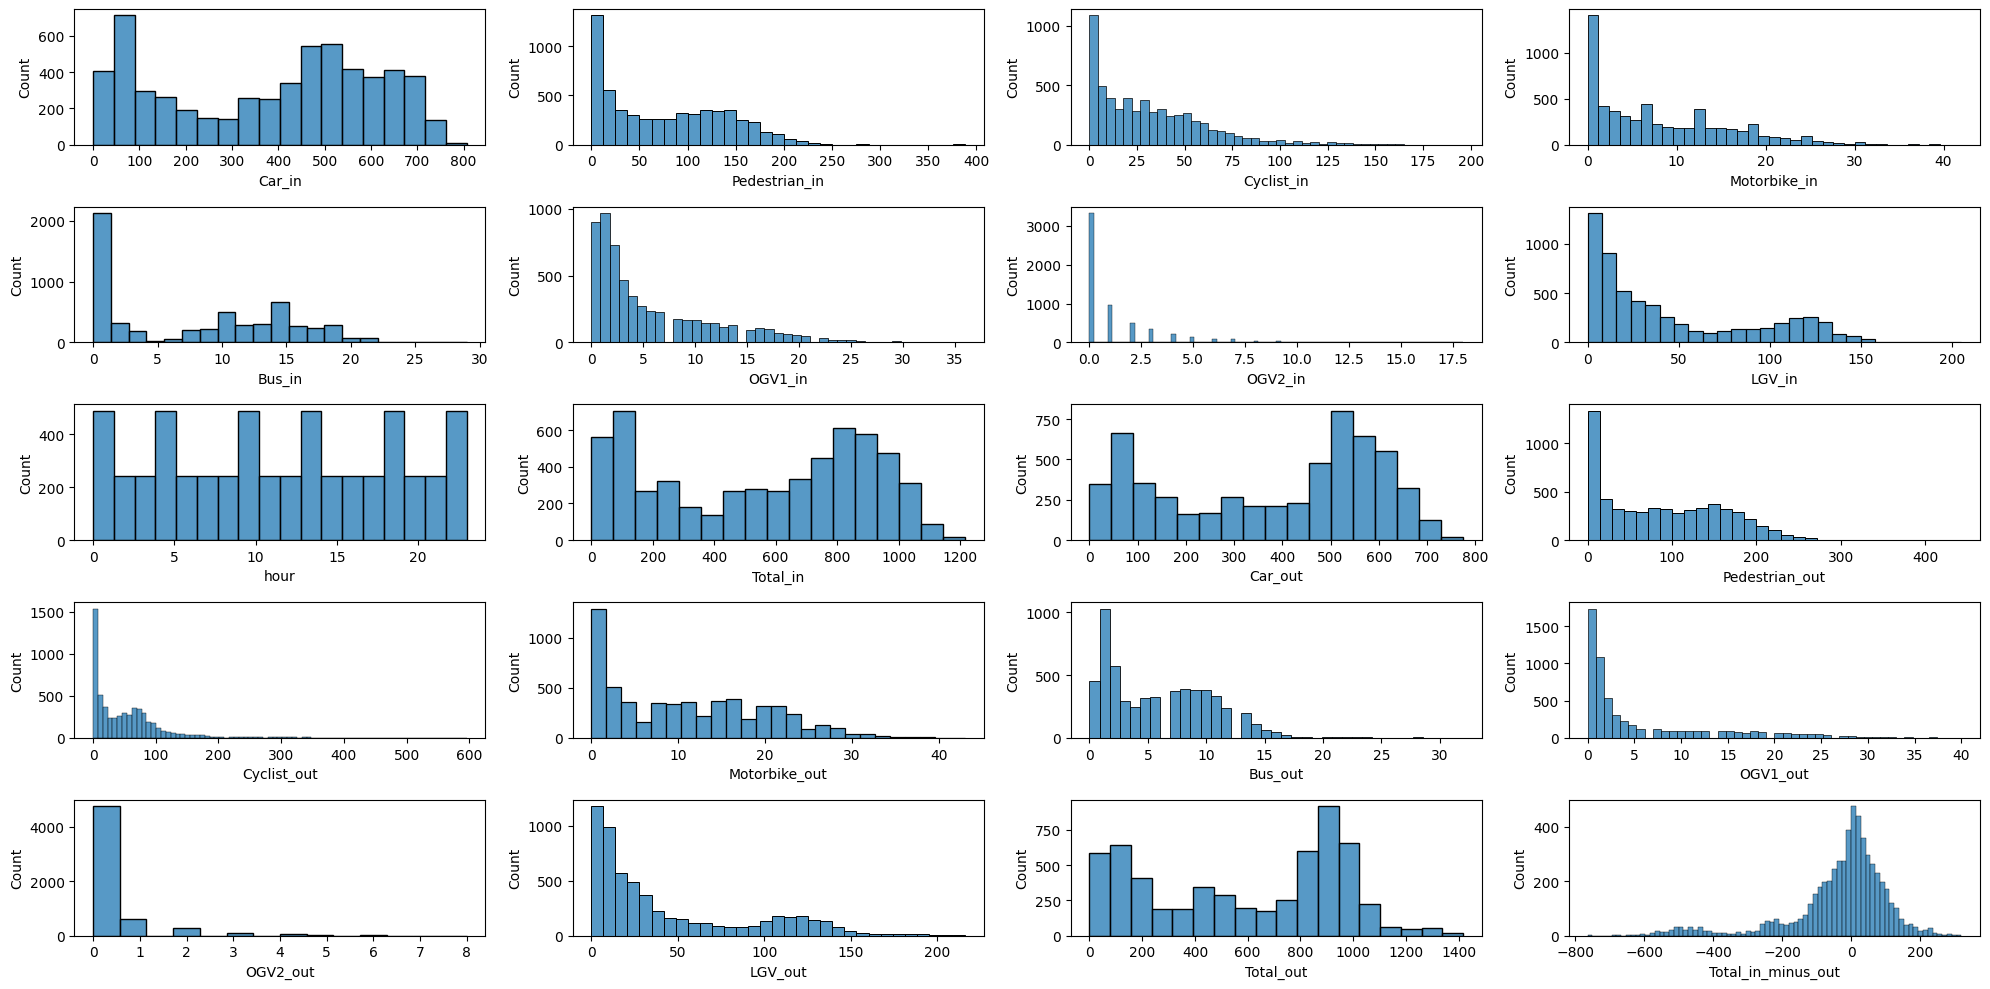

In [32]:
Plotsgrid(df_sensors_in_out_sensor_numeric).histplots()

<b> Observations: </b>
<p>
<ol>
<li>  Upto 800 cars travel in and out of the intersection in an hour. The distribution appears to be bimodal, with peaks around roughly 70 ad 550 respectively, this could be due to different times of day, or times of year, or both. 
<li> Most kinds of traffic have their peak frequency close to zero, which makes sense because traffic will be light during the night hours. Cars are the exception to this indicating that this mode of transportation is active for more hours throughout the day
<li> Looks like certain hours are more heavily represented in the data than others; this could potentially make the data more accurate for those hours than others, and might need to be managed in the analysis
<li> It'd be expected to have as much traffic leaving the intersection at any given hour as entering. While the total_in_minus_out's mean of zero makes sense, it's left skewed distribution (more traffic leaving than entering?) and wide tails do not. This should be further explored
</ol>
</p>
<p>
East 10, where this sensor is located, seems to be a rather busy intersection with lots of different kinds of traffic!
</p>

### Explore the in-out question

In [33]:
df_sensors_in_out_sensor_numeric.describe()

,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,OGV1_in,OGV2_in,LGV_in,hour,Total_in,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
count,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000
mean,379.682379,76.601474,32.065821,8.172095,7.759685,5.659068,1.245972,45.634727,11.496572,556.821220,380.803051,89.255399,52.549194,10.827905,5.931094,5.523654,0.318306,43.987659,589.196263,-32.375043
std,226.594141,62.135311,29.107905,7.502731,6.970181,6.068144,2.163948,44.890908,6.924050,344.320145,216.073846,70.401741,59.434933,8.916659,4.694440,7.638601,0.807973,46.554089,364.840815,145.091074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-764.000000
25%,142.000000,15.000000,7.000000,2.000000,1.000000,1.000000,0.000000,9.000000,5.000000,188.250000,148.000000,17.000000,7.000000,2.000000,1.000000,0.000000,0.000000,8.000000,198.000000,-75.000000
50%,439.000000,69.000000,26.000000,6.000000,8.500000,3.000000,0.000000,27.000000,11.000000,630.000000,460.000000,82.000000,39.000000,10.000000,6.000000,2.000000,0.000000,23.000000,662.000000,0.000000
75%,565.000000,128.000000,48.000000,13.000000,14.000000,9.000000,2.000000,82.000000,17.000000,860.000000,561.000000,148.000000,77.000000,18.000000,9.000000,8.000000,0.000000,71.000000,913.000000,51.000000
max,807.000000,388.000000,196.000000,42.000000,29.000000,36.000000,18.000000,205.000000,23.000000,1216.000000,775.000000,443.000000,596.000000,43.000000,32.000000,40.000000,8.000000,216.000000,1417.000000,320.000000


In [34]:
# Let's filter for the data where in-out is high
df_abnormal_traf_flow=df_sensors_in_out_sensor_numeric[abs(df_sensors_in_out_sensor_numeric['Total_in_minus_out'])>50]
df_abnormal_traf_flow.head()

,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,OGV1_in,OGV2_in,LGV_in,hour,Total_in,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
Local Time (Sensor),,,,,,,,,,,,,,,,,,,,
2019-06-03 01:00:00,89,9,4,2,1,0,0,5,1,110,51,6,0,0,0,1,0,1,59,51
2019-06-03 05:00:00,85,2,9,1,1,3,1,15,5,117,119,8,19,4,1,5,0,34,190,-73
2019-06-03 06:00:00,161,13,31,1,1,6,3,35,6,251,303,27,38,13,5,13,1,58,458,-207
2019-06-03 07:00:00,319,34,22,6,11,12,6,86,7,496,561,90,137,21,4,11,1,141,966,-470
2019-06-03 08:00:00,472,85,47,7,17,11,7,85,8,731,588,164,314,15,4,21,2,136,1244,-513


Nothing obvious about why the flow could be negative. <br>Are there multiple sensors at this location that each capture a certain portion? Maybe the entire flow is caught by all sixteen sensors. Instead of looking at one sensor, lets look at the data distributions for all of them.

In [35]:
(df_sensors_in_out[['Total_in','Total_out','Total_in_minus_out']]).describe()

,Total_in,Total_out,Total_in_minus_out
count,262530.000000,262530.000000,262530.000000
mean,115.570358,125.563414,-9.993056
std,216.528729,239.156390,78.719554
min,0.000000,0.000000,-1071.000000
25%,0.000000,0.000000,-3.000000
50%,0.000000,0.000000,0.000000
75%,118.000000,128.000000,0.000000
max,1246.000000,1912.000000,716.000000


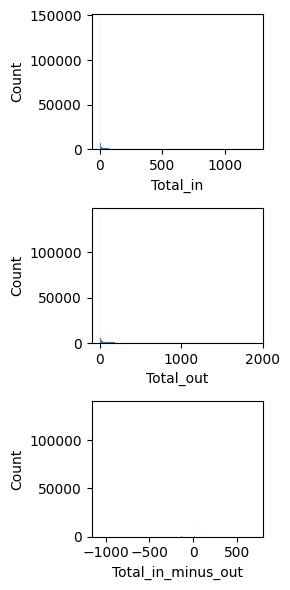

In [36]:
Plotsgrid(df_sensors_in_out[['Total_in','Total_out','Total_in_minus_out']]).histplots()

<li> This gives a much more reasonable picture. The net flow across all sensors is close to zero and roughly equal amounts of traffic enter and leave (in and out). 
<li>While not mentioned directly in the source, it is possible that 'in and 'out' correspond to each direction of a two-way street, so they could have different numbers.
<li> Referring back to the sensors map from earlier, this might explain why while the net flow for each sensor is not zero, the flow across all sixteen sensors that span most of the roads going into or out of the area would have a net flow of zero
<p><b>
<br> Therefore, it seems we should focus on data from all sensors. This would model a real intersection better where traffic is multi-directional and net flow is close to zero <b>

## Variable Selection

<i> What variable to focus on? </i>
<br> A real world traffic signal will probably time based on the <i>traffic outflow</i>. 
<br> Traffic enters the intersection with the goal of leaving. If outflow drops to a low level (for example blocked traffic or even very little traffic), the signal might need to be timed more frequently to avoid traffic delay. 
<br> However too frequent timing can cause the intersection to be overwhelmed and the traffic to become disorderly.
<br> Therefore, we can choose '<b>Total_out</b>' as our dependent (target) variable

## Data Preparation

Since there are multiple sensor values at the same timestamp and we are interested in the total, we should sum the values at each timestamp. This will also give us a smaller array size that will be easier to work with

In [37]:
# Create aggregation dictionary (aggregate hour to mean and others to sum)
agg_dict = {col:'sum' if col != 'hour' else 'mean' for col in numeric_cols}
# Group by Local time using aggregation dictionary
df_sensors_in_out_timegrouped=df_sensors_in_out.groupby(by='Local Time (Sensor)').agg(agg_dict).sort_index()
df_sensors_in_out_timegrouped.head()

,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,OGV1_in,OGV2_in,LGV_in,hour,Total_in,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
Local Time (Sensor),,,,,,,,,,,,,,,,,,,,
2019-06-03 01:00:00,565,40,25,14,1,1,0,25,1.0,671,695,40,10,4,4,1,0,13,767,-96
2019-06-03 02:00:00,388,27,12,1,0,3,1,25,2.0,457,731,26,4,1,2,1,0,16,781,-324
2019-06-03 03:00:00,388,11,10,3,0,1,0,24,3.0,437,685,20,8,1,2,1,1,18,736,-299
2019-06-03 04:00:00,297,10,26,9,4,9,1,38,4.0,394,397,66,50,8,3,5,0,44,573,-179
2019-06-03 05:00:00,580,23,71,16,4,10,8,105,5.0,817,764,91,130,26,5,19,5,133,1173,-356


In [38]:
# Check for first timestamp
first_timestamp=df_sensors_in_out.index[0]
df_sensors_in_out.loc[first_timestamp,numeric_cols].sum(axis=0)-df_sensors_in_out_timegrouped.head(1)

,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,OGV1_in,OGV2_in,LGV_in,hour,Total_in,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
Local Time (Sensor),,,,,,,,,,,,,,,,,,,,
2019-06-03 01:00:00,0,0,0,0,0,0,0,0,44.0,0,0,0,0,0,0,0,0,0,0,0


This suggests that the grouping is performed correctly

In [39]:
df_sensors_in_out_timegrouped.describe()

,Car_in,Pedestrian_in,Cyclist_in,Motorbike_in,Bus_in,OGV1_in,OGV2_in,LGV_in,hour,Total_in,Car_out,Pedestrian_out,Cyclist_out,Motorbike_out,Bus_out,OGV1_out,OGV2_out,LGV_out,Total_out,Total_in_minus_out
count,5831.000000,5831.000000,5831.000000,5831.00000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000
mean,3616.733493,486.972560,458.143886,68.26805,90.355171,41.372663,10.401818,431.094152,11.501972,5203.341794,3784.607271,683.337849,582.781341,76.758875,85.044075,39.619448,8.534385,392.577431,5653.260676,-449.918882
std,2485.629562,420.399881,451.826121,55.85162,78.258501,47.571561,14.354621,439.219574,6.921735,3686.385789,2613.506957,574.306926,613.051713,60.087645,76.214741,50.121339,14.091680,410.011524,4057.612080,590.842349
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3167.000000
25%,1097.000000,85.000000,75.000000,18.00000,11.000000,8.000000,1.000000,68.000000,6.000000,1393.500000,1159.000000,113.000000,83.500000,19.000000,11.000000,6.000000,0.000000,58.000000,1508.000000,-740.500000
50%,3727.000000,431.000000,362.000000,61.00000,77.000000,19.000000,4.000000,248.000000,12.000000,5365.000000,3967.000000,636.000000,453.000000,74.000000,68.000000,14.000000,2.000000,203.000000,5914.000000,-328.000000
75%,5397.500000,782.000000,689.000000,103.00000,156.000000,65.000000,14.000000,779.000000,17.500000,8068.500000,5573.000000,1110.500000,864.000000,119.000000,140.000000,63.000000,10.000000,724.000000,8746.500000,9.000000
max,9292.000000,2432.000000,2896.000000,324.00000,294.000000,238.000000,107.000000,1944.000000,23.000000,14952.000000,9835.000000,2811.000000,4189.000000,371.000000,316.000000,280.000000,164.000000,1658.000000,16932.000000,794.000000


<Axes: >

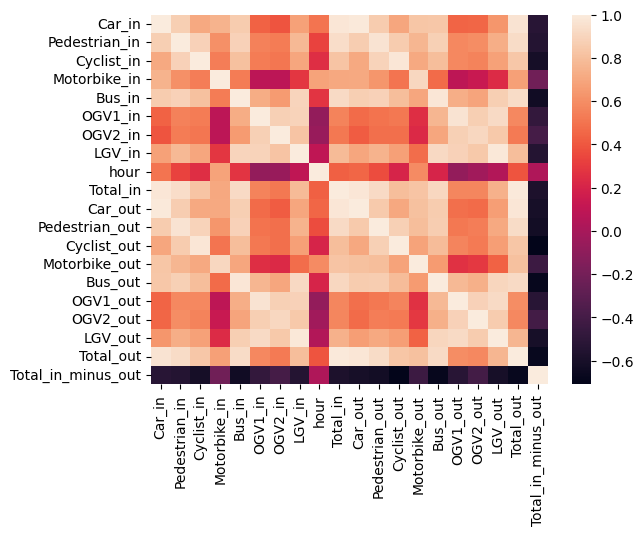

In [40]:
# Plot a correlation heatmap
sns.heatmap(df_sensors_in_out_timegrouped.corr())

Considering we want to model Outflow, lets tabulate the correlations of that variable w.r.t. others

<Axes: >

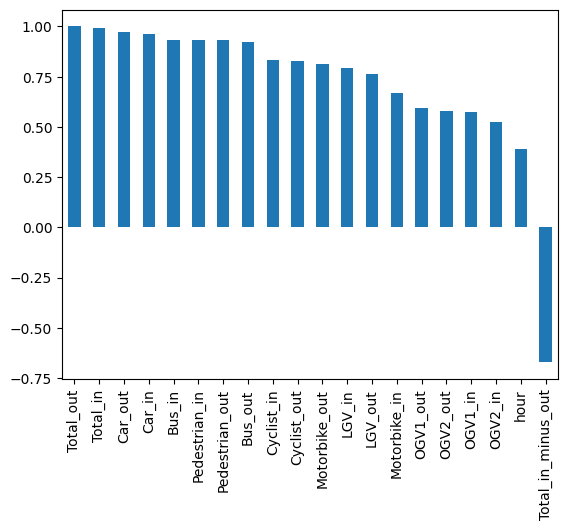

In [41]:
# Correlations for outflow
df_sensors_in_out_timegrouped.corr().loc['Total_out'].sort_values(ascending=False).plot(kind='bar')

<b> Looks like almost all other variables have a moderate or strong correlation to outflow, except 'hour'</b>

<Axes: xlabel='hour', ylabel='Total_out'>

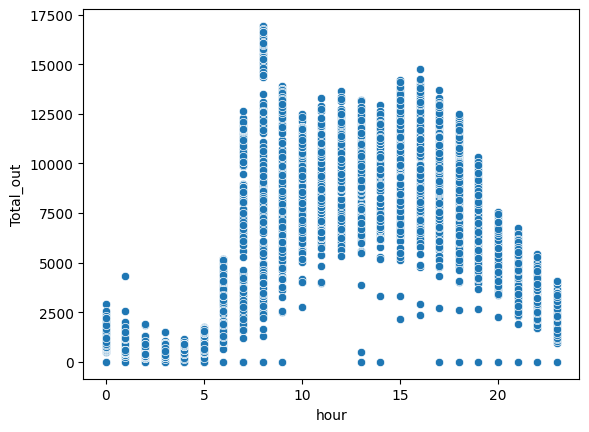

In [42]:
#Explore the relationship of outflow with hour
sns.scatterplot(data=df_sensors_in_out_timegrouped,x='hour',y='Total_out')

This suggests that across all months, the traffic outflow increases from roughly 5 am to 9 am, remains about the same till around 5 pm, then begins to drop after. This could indicate a repeated pattern, or seasonality. Let's look at the time series plot

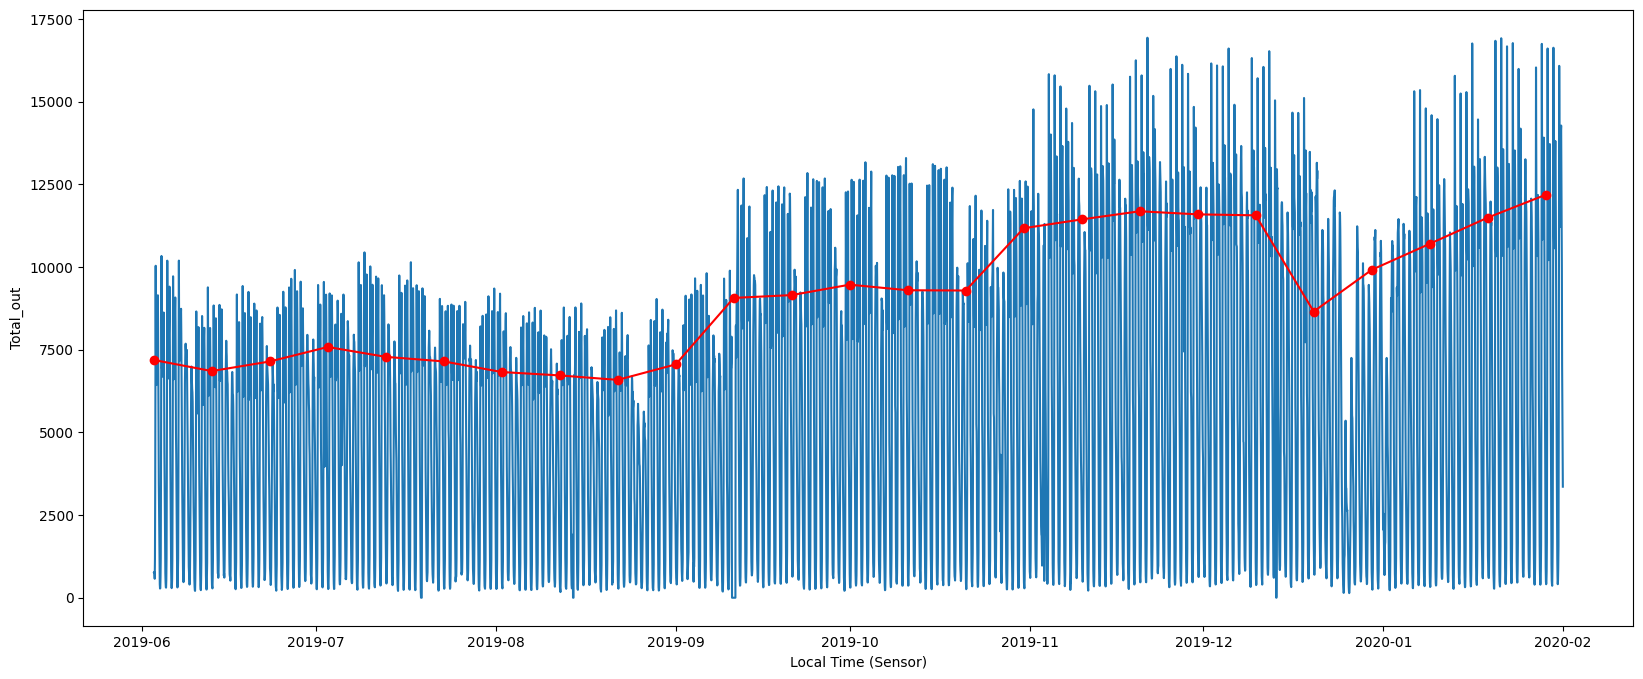

In [43]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df_sensors_in_out_timegrouped,x=df_sensors_in_out_timegrouped.index,y='Total_out')
plt.plot(df_sensors_in_out_timegrouped['Total_out'].resample('10D').quantile(.75),'-or')

<li> We further see that traffic is low during late summer (June to august), starts increasing between september to december and then drops sharply towards the end of december before picking up again. The drop in december might be attributed to Christmas 
<li> Based on the limited data we have available, we can conclude that there is a trend, as well as seasonality and cyclicality

## Modeling

### Time Series Forecasting - ARMA based models
<p>
ARMA (Autoregressive Moving Average) is a time series model used for forecasting and analyzing the behavior of time-series data. It is a combination of two components: the Autoregressive (AR) model and the Moving Average (MA) model.

Autoregressive (AR) Model:
The AR model assumes that the current value of a time series can be expressed as a linear function of its past values.
The order of the AR model is denoted as p, which represents the number of past values used to predict the current value.
Moving Average (MA) Model:
The MA model assumes that the current value of a time series can be expressed as a linear function of the current and past error terms (the difference between the actual value and the predicted value).
The order of the MA model is denoted as q, which represents the number of past error terms used to predict the current value.
The ARMA model combines these two components, and the model is denoted as ARMA(p,q), where:

p is the order of the Autoregressive (AR) component
q is the order of the Moving Average (MA) component
<br>The general form of the ARMA(p,q) model is:
<br>
X_t = c + φ_1 * X_(t-1) + φ_2 * X_(t-2) + ... + φ_p * X_(t-p) + 
      ε_t + θ_1 * ε_(t-1) + θ_2 * ε_(t-2) + ... + θ_q * ε_(t-q)
<br>where:
<br>X_t is the observed value of the time series at time t
<br>c is a constant term
<br>φ_1, φ_2, ..., φ_p are the parameters of the AR component
<br>θ_1, θ_2, ..., θ_q are the parameters of the MA component
<br>ε_t is the error term at time t
</p>

### Data Preparation

Let's explore some scaling options for preparing the data

In [44]:
standardscaler=StandardScaler()
minmaxscaler=MinMaxScaler()
logtransform=FunctionTransformer(np.log1p, validate=True)

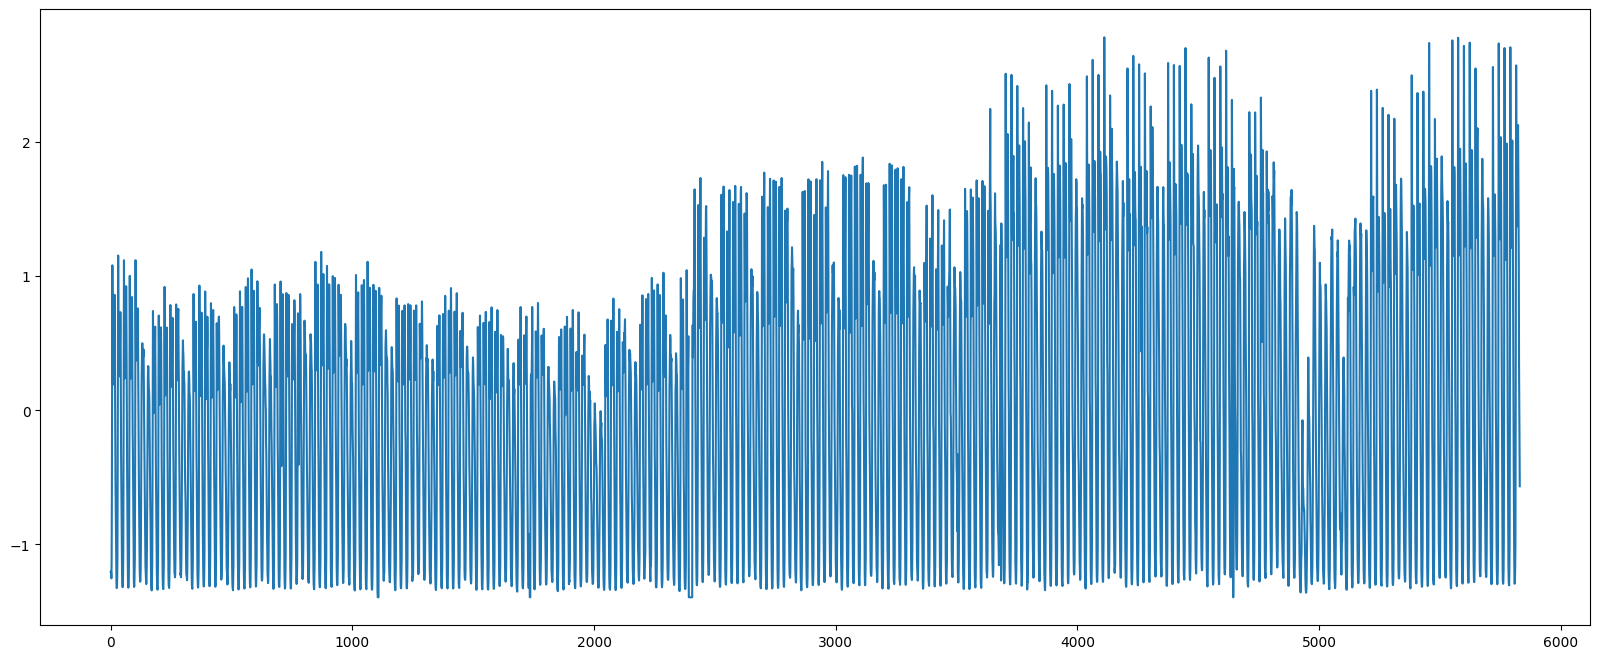

In [45]:
# StandardScaler
plt.figure(figsize=(20,8))
plt.plot(standardscaler.fit_transform(df_sensors_in_out_timegrouped['Total_out'].values.reshape(-1,1)))

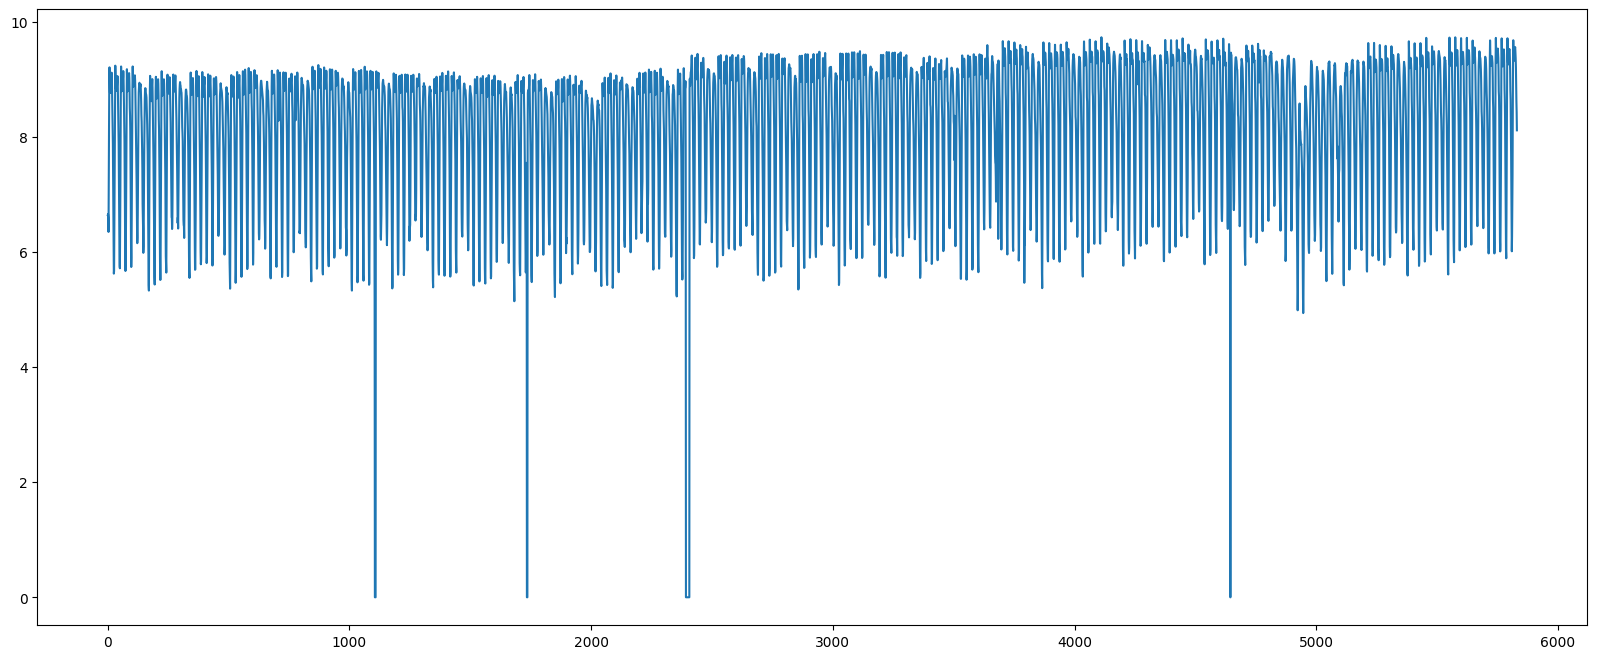

In [46]:
# Log Scaling
plt.figure(figsize=(20,8))
plt.plot(logtransform.fit_transform(df_sensors_in_out_timegrouped['Total_out'].values.reshape(-1,1)))

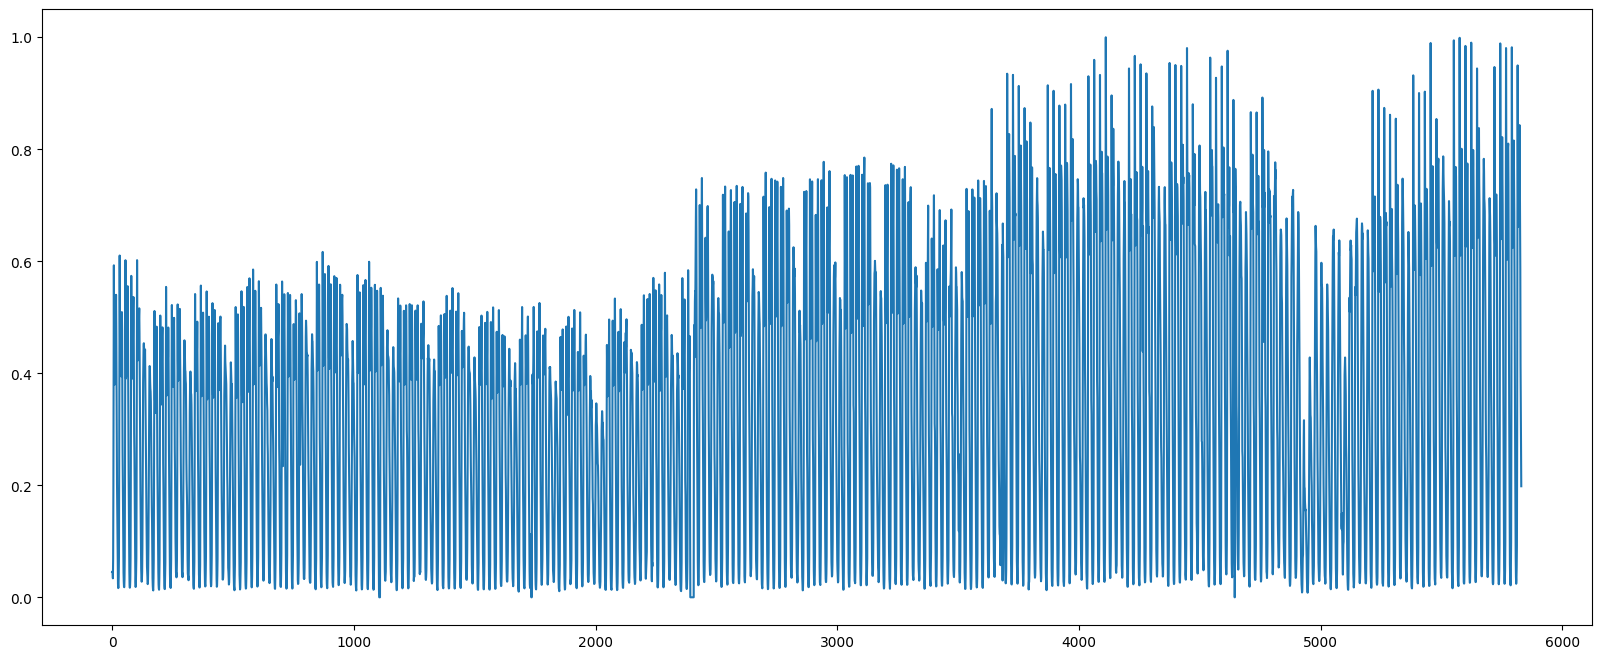

In [47]:
# MinMax Scaer
plt.figure(figsize=(20,8))
plt.plot(minmaxscaler.fit_transform(df_sensors_in_out_timegrouped['Total_out'].values.reshape(-1,1)))

<li> Since we expect the data to have a trend, standard scaler is probably not the best option
<li> Using log scaling drastically improves the order of magnitude but still retains the patterns of the deep valleys
<li> MinMax scaling gives us data that is not as heavily distributed while retaining most of the original patterns in the data. Hence we can select this scaling method

Prepare data for training and evaluation, and testing (80-20). Since this is time series data, we cannot select random training and testing points because the mode has to learn time varying patterns in the data. So we select the initial 80% for training and remaining 20% for testing

In [48]:
n=df_sensors_in_out_timegrouped.shape[0]
n_train=int(.8*n)
train_inds=np.arange(n_train+1)
test_inds=np.arange(n_train+1,n)
print(n,n_train,train_inds[-1],test_inds[-1])

5831 4664 4664 5830


In [49]:
X,y=df_sensors_in_out_timegrouped.reset_index().index.values,df_sensors_in_out_timegrouped['Total_in'].values

In [50]:
X_train,X_test,y_train,y_test=X[train_inds],X[test_inds],y[train_inds],y[test_inds]